In [2]:
import pandas as pd

In [3]:
base = "../data"

In [4]:
df = pd.read_csv(f"{base}/train_preprocessed.csv")
df.sample(3)

,comment_text,id,identity_hate,insult,obscene,set,severe_toxic,threat,toxic,toxicity
50001,done dialogue stalk me,85a8f92bbd4643d4,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0
102013,hi thomas thanks for welcoming me to wikipedia,21edfc0ea25a9ca3,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0
52409,layla is attacking this woman and it is just p...,8c3a9b672694b01a,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0


In [4]:
df.shape

(159571, 10)

In [5]:
df_ = pd.read_csv(f"{base}/test_preprocessed.csv")
df = pd.concat([df, df_])
df.shape

(312735, 10)

Text(0.5, 0, 'class')

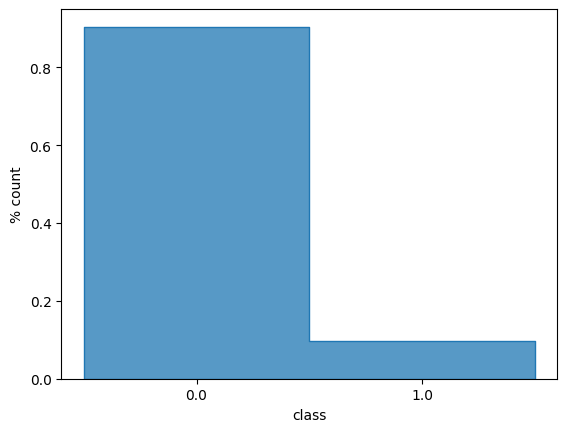

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

df_copy = df.copy()
df_copy['toxic'] = df_copy['toxic'].astype('str')

sns.histplot(
    data=df_copy,
    x='toxic',
    element="step",
    stat='density',
    common_norm=False
)

plt.ylabel('% count')
plt.xlabel('class')

In [9]:
df2 = pd.read_csv(f"{base}/youtoxic_english_1000.csv")
df2.sample(3)

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
390,Ugi28hnRXGuoEngCoAEC,9pr1oE34bIM,Just so everyone knows more white people die f...,False,False,False,False,False,False,False,False,False,False,False,False
679,UgyJiThWVO-eQ03ikjt4AaABAg,cT14IbTDW2c,Would’ve been satisfying if someone threw a Mo...,True,True,False,True,False,False,False,False,False,False,False,False
206,UgjWd_JsIlOo9XgCoAEC,4rCweDxDqdw,heard a Billionaire funded these organised rio...,True,True,False,False,True,False,False,False,False,False,False,False


Text(0.5, 0, 'class')

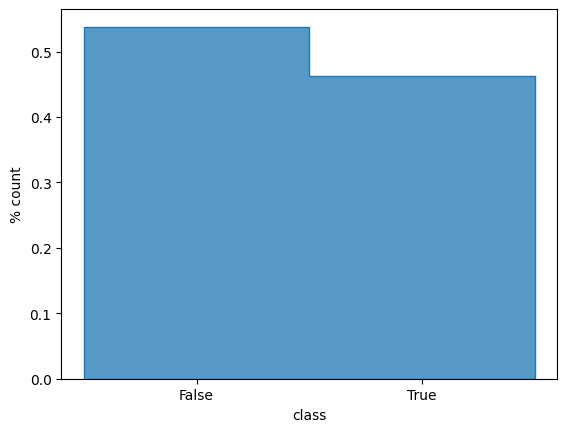

In [14]:
df2_copy = df2.copy()
df2_copy['IsToxic'] = df2_copy['IsToxic'].astype('str')

sns.histplot(
    data=df2_copy,
    x='IsToxic',
    element="step",
    stat='density',
    common_norm=False
)

plt.ylabel('% count')
plt.xlabel('class')

Будем заниматься бинарной классификацией для предсказанания целевой переменной isToxic. В качестве метрики используем *f1-score*

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def show_model_perfection_metrics(y_test, y_pred):
    print('F1: ', f1_score(y_test, y_pred, average='weighted'))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.show()

Проведём лемматизацию данных

In [18]:
import string
from typing import List

import nltk
import pandas as pd

nltk.download('wordnet')
nltk.download("omw-1.4")
nltk.download('stopwords')

stopwords = set(nltk.corpus.stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()
translator = str.maketrans('', '', string.punctuation)

def pre_process(text):
    text = text.lower()
    text = text.translate(translator)
    text = ' '.join(text.split())
    return text

def lemmatize(word):
    word = lemmatizer.lemmatize(word, pos="v")
    word = lemmatizer.lemmatize(word, pos="a")
    word = lemmatizer.lemmatize(word, pos="r")
    word = lemmatizer.lemmatize(word, pos="n")
    return word

def remorph(text):
    return ' '.join([lemmatize(word) for word in text.split()])

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stopwords])

def prefactoring(text):
    if text is None or not isinstance(text, str):
        raise ValueError('Text must be a string')

    text = pre_process(text)
    text = remorph(text)
    text = remove_stopwords(text)
    return text

def refactor_data(data: List[str] | pd.Series) -> List[str]:
    if isinstance(data, pd.Series):
        data = data.tolist()
    if data is None or not isinstance(data, list) or not all(isinstance(review, str) for review in data):
        raise ValueError('Data must be a list of strings')

    return [
        prefactoring(text)
        for text in data
    ]


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\setday\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\setday\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\setday\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
df_lemmatized = df.copy()
df_lemmatized['comment_text'] = refactor_data(df_lemmatized['comment_text'])
df_lemmatized.sample(3)

,comment_text,id,identity_hate,insult,obscene,set,severe_toxic,threat,toxic,toxicity
8853,move modify provide source secondary one matter,177f048d11b3b551,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0
7569,think like even say right agree still express ...,1422e7fe548ef5d8,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0
153705,best tell nobody use phrase leave wing day exc...,a132068cb707eb61,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0


In [20]:
df2_lemmatized = df2.copy()
df2_lemmatized['comment_text'] = refactor_data(df2_lemmatized['Text'])
df2_lemmatized.sample(3)

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism,comment_text
317,UggX2vkvXl3xuHgCoAEC,9pr1oE34bIM,The one part that is hard to believe is that t...,False,False,False,False,False,False,False,False,False,False,False,False,one part hard believe guy run officer shoot dr...
403,UgiDwqea9kPlTXgCoAEC,9pr1oE34bIM,This man has an intelligence the average black...,True,False,False,False,False,True,True,False,False,False,False,False,man intelligence average black man cant compre...
20,UggtH27r-TTcZHgCoAEC,04kJtp6pVXI,"I think ,he kill him",True,True,False,False,False,False,False,False,False,False,False,False,think kill
